In [ ]:
                                    ##############################################
                                    ##############################################

                                                       Retention

                                    ##############################################
                                    ##############################################

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
plt.style.use('ggplot')                       # Красивые графики
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
path_to_registration_data = '/home/jupyter-v.startu-4/shared/problem1-reg_data.csv'
path_to_authorization_data = '/home/jupyter-v.startu-4/shared/problem1-auth_data.csv'

In [4]:

#  Функция для сборки данных из разных таблиц. 

def data_consolidation():
    
    df1 = pd.read_csv(path_to_registration_data, sep=';')
    df2 = pd.read_csv(path_to_authorization_data, sep=';')
    
    df1.reg_ts = df1.reg_ts.apply(lambda x: datetime.datetime.fromtimestamp(x).date())
    df2.auth_ts = df2.auth_ts.apply(lambda x: datetime.datetime.fromtimestamp(x).date())
  
    full_data = df2.merge(df1, how='left', on='uid')
    
    return full_data

In [5]:
full_data = data_consolidation()

In [6]:
#  Посмотрим на данные

full_data

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-23,2,1999-07-23
2,1999-07-25,2,1999-07-23
3,1999-07-31,2,1999-07-23
4,1999-08-05,2,1999-07-23
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [ ]:

#   Напишем функцию retention с аргументами и блоком визуализации на выбор.

#   df - данные для расчёта
#   last_n_days - количество последних дней, за которые мы посмотрим retention
#   dates - можно указать определённые даты, чтобы не отвлекаться на все когорты
#   zoom - увеличиваем масштаб графика, presentation_type = 'line'
#   rolling_chart - можем "сгладить" график, для определения общей тенденции 
#   presentation_type - 'line' (линейный график), 'style' (стильная табличка с когортами)


In [23]:
def retention(df, last_n_days=30, dates=[], zoom=105, rolling_chart=False, presentation_type='line'):
    
    #  Определим последний день в данных и день с которого начнём смотреть retention.
    
    last_day = df.reg_ts.max()
    first_day = last_day - pd.offsets.Day(last_n_days)
    
    #  Преобразуем данные и создадим Pivot table, где в индексах дни-когорты, а в колонках N_Day.
    
    cohorts = df.query('reg_ts > @first_day').rename(columns={'reg_ts': 'Reg_Day_', 'auth_ts': 'Auth_Day'})
    cohorts['N_Day'] = (cohorts['Auth_Day'] - cohorts['Reg_Day_']).dt.days
    cohorts['Reg_Day'] = cohorts['Reg_Day_'].apply(lambda x: x.strftime('%Y-%m-%d'))
    cohorts = cohorts\
                        .groupby(['Reg_Day', 'Auth_Day', 'N_Day'], as_index=False)\
                        .agg({'uid': pd.Series.nunique})\
                        .rename(columns={'uid': 'Total_Users'})\
                        .pivot(index='Reg_Day', columns='N_Day', values='Total_Users')
 
    #  Определим размеры каждой когорты

    cohort_group_size = cohorts[0]
    
    #  Разделим количество пользователей в каждый день для каждой когорты на размер когорты.
    
    user_retention = cohorts.divide(cohort_group_size, axis=0)
    
    #  Создадим таблицу для представления в виде линейного графика, транспонировав предыдущую таблицу.
    
    users = user_retention.T
    
    
    #  Напишем функцию для стильной таблицы.
    
    
    def make_style(df):
        return (df
                    .style
                    .set_caption('User retention by cohort')
                    .set_table_styles([{
                                    'selector': 'caption',
                                    'props': [
                                        ('color', 'black'),
                                        ('font-size', '25px'),
                                        ('text-align','center')
                                    ]
                                }])       # добавляем подпись
                    .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
                    .highlight_null('white')  # делаем белый фон для значений NaN
                    .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    
    
    if presentation_type == 'line':
        
        if dates:
            try:
                if rolling_chart:
                    ax = users[dates].rolling(4).mean().plot(linewidth=2, markersize=4, marker='o')
                else:
                    ax = users[dates].plot(linewidth=2, markersize=6, marker='o')
            except KeyError:
                return f'Не все выбранные даты входят в наблюдаемый интервал времени {first_day.date()} - {last_day}. Пожалуйста, задайте даты-когорты снова.'
        else:
            if rolling_chart:
                ax = users.rolling(4).mean().plot(linewidth=2, markersize=4, marker='o')
            else:
                ax = users.plot(linewidth=2, markersize=4, marker='o')

                
        
        #  Дополнительная визуализация
        
        plt.title('Cohorts: User Retention', fontsize=30, pad=40)
        
        plt.xticks(np.arange(0, last_n_days, 1), fontsize=15) # разбивка оси X
        plt.xlabel('N_Day', fontsize=20, labelpad=30)
        plt.xlim(left=-1) #ось X
        
        plt.yticks(np.arange(0, 1.1, 0.1), fontsize=15)
        plt.ylabel('Cohort Retention', fontsize=20, labelpad=30)
        plt.ylim(0, zoom/100)
        
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax.grid(which='minor',
                color = 'black',
                linewidth=0.2,
                linestyle = '--')
        ax.tick_params(axis='both', which = 'both', color='white')
        
        plt.legend(facecolor='white', framealpha=1, labelspacing=0.5, fontsize=11)
        
        ax.set_facecolor('white')
        ax.grid(which='major',color='black', linewidth=0.5, linestyle='--')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:,g}%'.format(y*100)))
        sns.despine()
    elif presentation_type == 'style':
        if dates:
            try:
                
                return make_style(user_retention.loc[dates])
          
            except KeyError:
                
                return f'Не все выбранные даты входят в наблюдаемый интервал времени {first_day.date()} - {last_day}. Пожалуйста, задайте даты-когорты снова.'
        else:
            return make_style(user_retention)
  
    

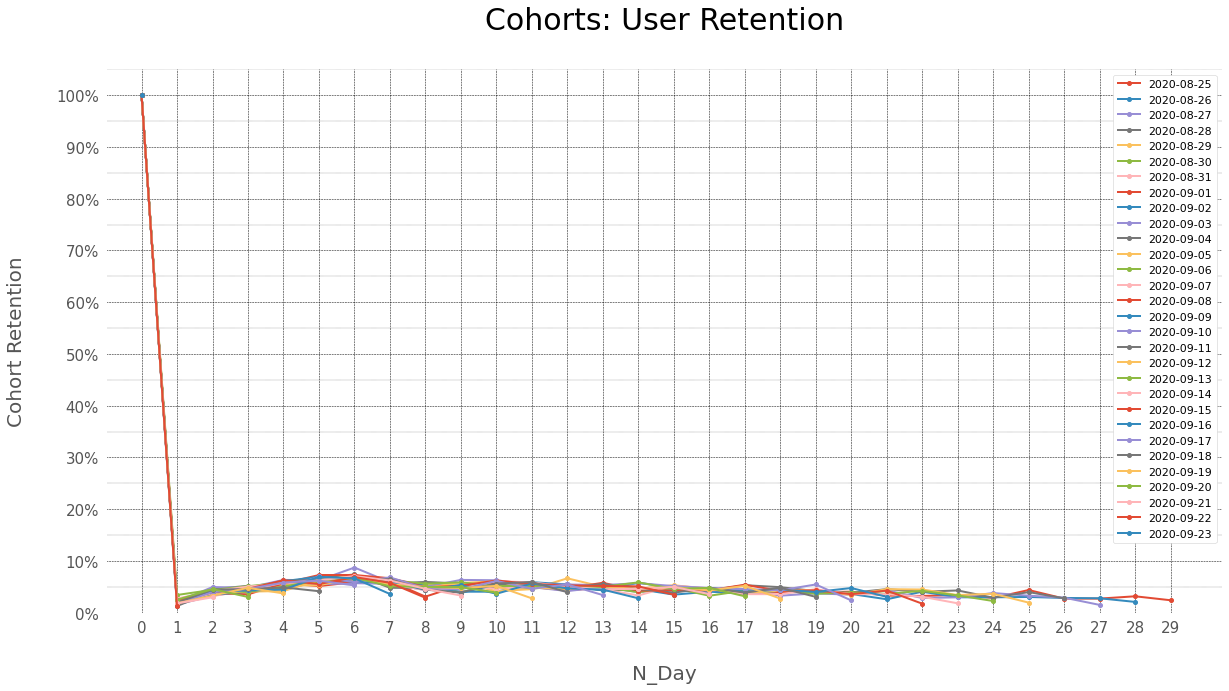

In [24]:

#  Построим график по умолчанию. Понятно одно - Retention, мягко говоря, невелик.

retention(full_data)

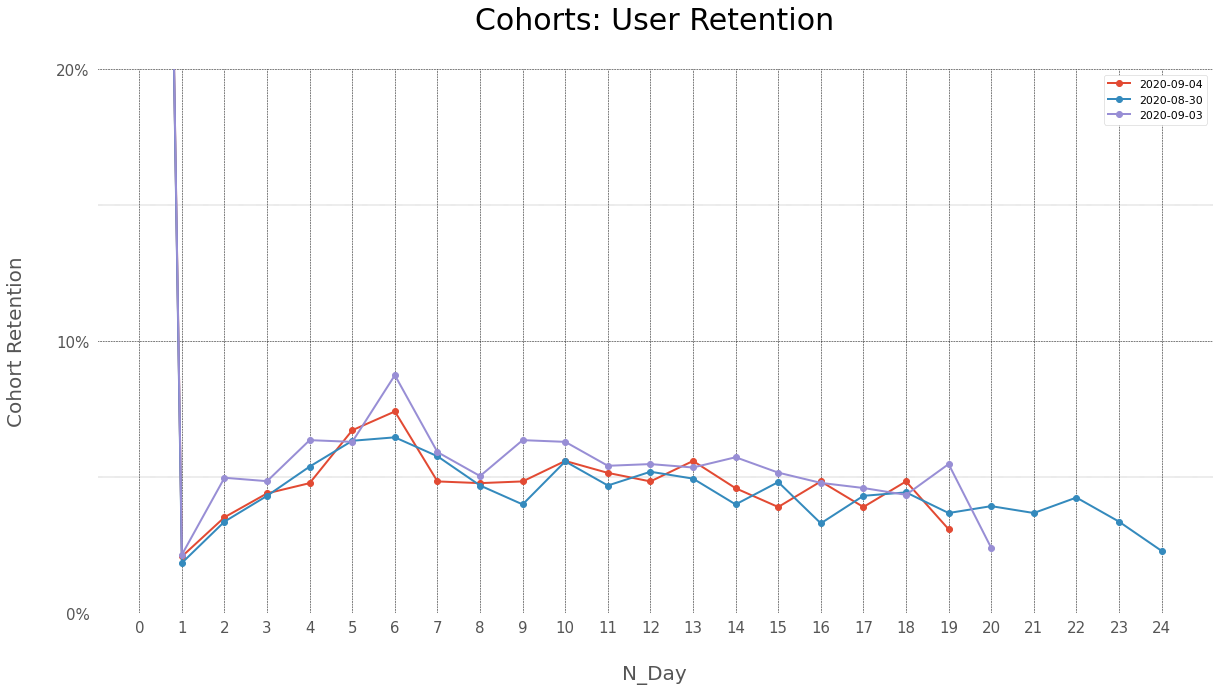

In [9]:

#  А тут выберем последние 25 дней, 3 определённые даты и посмотрим поближе(zoom)

retention(full_data, 25, ['2020-09-04', '2020-08-30', '2020-09-03'], 20)

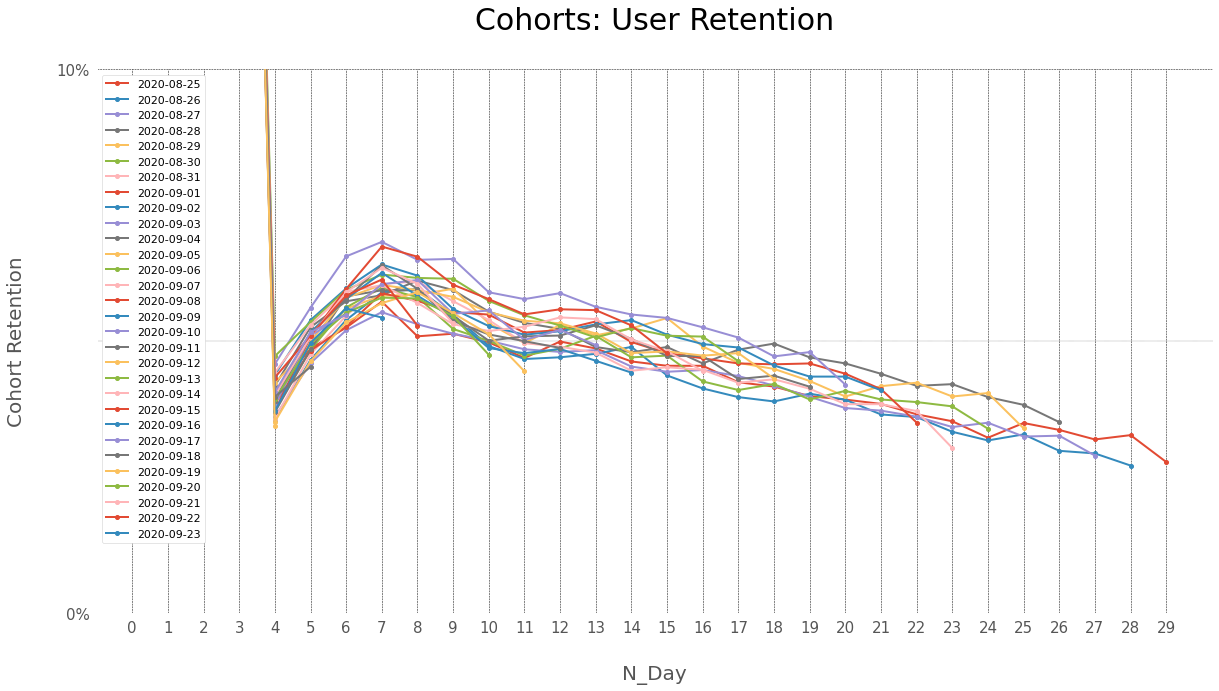

In [10]:

#    А как выглядит 'сглаживание'? Даже при построении 30 когорт видна чёткая направленность.
#    Видно, что при резком падении в первый же день к концу первой недели retention растёт, 
#    но потом необратимо уменьшается. Есть над чем подумать.

retention(full_data, 30, zoom=10, rolling_chart=True)

In [11]:

#    Если ошибёмся с датами, увидим сообщение.

retention(full_data, 25, ['2020-09-04', '2020-07-30'])

'Не все выбранные даты входят в наблюдаемый интервал времени 2020-08-29 - 2020-09-23. Пожалуйста, задайте даты-когорты снова.'

In [12]:

#    А где же обещанная стильная таблица? Укажем аргумент presentation_type='style'

retention(full_data, 18, presentation_type='style')

N_Day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Reg_Day,,,,,,,,,,,,,,,,,,
2020-09-06,100.00%,3.44%,4.44%,5.13%,5.88%,5.94%,6.82%,6.25%,5.63%,5.88%,5.19%,5.19%,4.88%,5.00%,5.88%,4.63%,4.82%,3.19%
2020-09-07,100.00%,2.75%,4.18%,5.06%,5.68%,6.25%,6.62%,5.56%,4.37%,4.68%,6.12%,5.87%,5.06%,4.56%,4.62%,5.00%,3.62%,
2020-09-08,100.00%,1.81%,3.81%,3.56%,5.68%,7.30%,7.30%,6.67%,4.93%,5.24%,6.24%,5.55%,5.30%,5.18%,5.12%,3.49%,,
2020-09-09,100.00%,1.93%,3.48%,4.11%,6.10%,6.97%,5.91%,6.04%,4.42%,5.35%,3.67%,5.66%,4.73%,4.48%,2.80%,,,
2020-09-10,100.00%,1.93%,4.29%,4.66%,4.41%,7.02%,5.90%,6.84%,4.72%,4.54%,6.15%,4.66%,5.47%,3.42%,,,,
2020-09-11,100.00%,1.30%,4.10%,3.97%,6.21%,6.27%,6.64%,6.46%,4.47%,3.91%,5.65%,5.96%,3.97%,,,,,
2020-09-12,100.00%,1.86%,3.90%,4.09%,4.21%,6.32%,6.75%,5.51%,5.02%,4.77%,5.20%,2.79%,,,,,,
2020-09-13,100.00%,2.16%,4.45%,4.02%,5.07%,6.25%,6.74%,5.13%,5.01%,4.95%,3.90%,,,,,,,
2020-09-14,100.00%,1.91%,3.83%,4.45%,5.81%,6.24%,7.10%,6.24%,4.63%,3.34%,,,,,,,,


In [28]:
# Можно выбрать произвольные даты и проследить за интересующими нас когортами, не отвлекаясь на остальные.

retention(full_data, 18, ['2020-09-07', '2020-09-18', '2020-09-21'], presentation_type='style')

N_Day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Reg_Day,,,,,,,,,,,,,,,,,,
2020-09-07,100.00%,2.75%,4.18%,5.06%,5.68%,6.25%,6.62%,5.56%,4.37%,4.68%,6.12%,5.87%,5.06%,4.56%,4.62%,5.00%,3.62%,
2020-09-18,100.00%,1.96%,4.48%,4.54%,4.91%,4.17%,,,,,,,,,,,,
2020-09-21,100.00%,1.83%,2.99%,,,,,,,,,,,,,,,


In [ ]:


Мы посмотрели на N-Day Retention. Честно говоря, не впечатляет. Может наши пользователи
возвращаются позже, например через неделю или ещё позже? Посмотрим. 
Поможет нам Rolling Retention по неделям. Напишем соотетствующую функцию.



In [19]:
def rolling_retention(df, last_n_weeks=4, presentation_type='line', zoom=105):
    
    last_day = df.reg_ts.max()
    first_day = last_day - pd.offsets.Day(last_n_weeks * 7)
    
    cohorts = df.query('reg_ts > @first_day')
    cohorts = cohorts\
                        .groupby(['uid', 'reg_ts'], as_index=False)\
                        .agg({'auth_ts': 'max'})\
                        .rename(columns={'auth_ts': 'last_activity'})
    
    cohorts['Reg_Day'] = cohorts['reg_ts']
    
    cohorts['Reg_Day'] = pd.to_datetime(cohorts['Reg_Day'], errors='coerce')
    
    cohorts['Cohorts'] = cohorts['Reg_Day'].dt.to_period('W').dt.to_timestamp().apply(lambda x: x.strftime('%Y-%m-%d'))

    cohorts['last_activity'] = pd.to_datetime(cohorts['last_activity'])

    cohorts['week_num_left'] = cohorts['last_activity'].dt.to_period('W').dt.to_timestamp().dt.isocalendar().week

    cohorts['week_num_start'] = cohorts['Reg_Day'].dt.to_period('W').dt.to_timestamp().dt.isocalendar().week

    cohorts['weeks_visited']  = cohorts[['week_num_left','week_num_start']].apply(lambda x: x['week_num_left']-x['week_num_start'], axis=1)

    cohorts['N_Week'] = cohorts['weeks_visited'].apply(lambda x:range(0,x))

    cohorts['Reg_Day'] = cohorts['Reg_Day'].dt.date
    
    cohorts = cohorts.sort_values(by='weeks_visited')
    
    cohorts = cohorts.explode('N_Week')
    
    cohorts['N_Week'] = cohorts['N_Week'].fillna(0)
    
    cohorts['clients'] = 1
    
    roll_ret_df = cohorts.pivot_table(index = 'Cohorts', 
                                              values = 'clients' , 
                                              columns = 'N_Week', aggfunc=np.sum).fillna(0).T
    roll_ret_df_norm = roll_ret_df.apply(lambda x: x/roll_ret_df.loc[0], axis = 1).applymap(lambda x: x if x!=0 else None)
    
        
    users = roll_ret_df_norm
    
    
    def make_style(df):
        return (df.T
                    .style
                    .set_caption('User Rolling-retention by cohort')
                    .set_table_styles([{
                                    'selector': 'caption',
                                    'props': [
                                        ('color', 'black'),
                                        ('font-size', '25px'),
                                        ('text-align','center')
                                    ]
                                }])       # добавляем подпись
                    .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
                    .highlight_null('white')  # делаем белый фон для значений NaN
                    .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    
    
    if presentation_type == 'line':
        
        ax = users.plot(linewidth=2, markersize=6, marker='o')
        
        plt.title('Rolling-Retention', fontsize=30, pad=40)
        
        plt.xticks(np.arange(0, last_n_weeks, 1), fontsize=15) # разбивка оси X
        plt.xlabel('N_Week', fontsize=20, labelpad=30)
        plt.xlim(left=-1) #ось X
        
        plt.yticks(np.arange(0, 1.1, 0.1), fontsize=15)
        plt.ylabel('Cohort Retention', fontsize=20, labelpad=30)
        plt.ylim(0, zoom/100)
        
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax.grid(which='minor',
                color = 'black',
                linewidth=0.2,
                linestyle = '--')
        ax.tick_params(axis='both', which = 'both', color='white')
        
        plt.legend(facecolor='white', framealpha=1, labelspacing=0.5, fontsize=11)
        
        ax.set_facecolor('white')
        ax.grid(which='major',color='black', linewidth=0.5, linestyle='--')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:,g}%'.format(y*100)))
        sns.despine()
    elif presentation_type == 'style':
        return make_style(users)
  
    

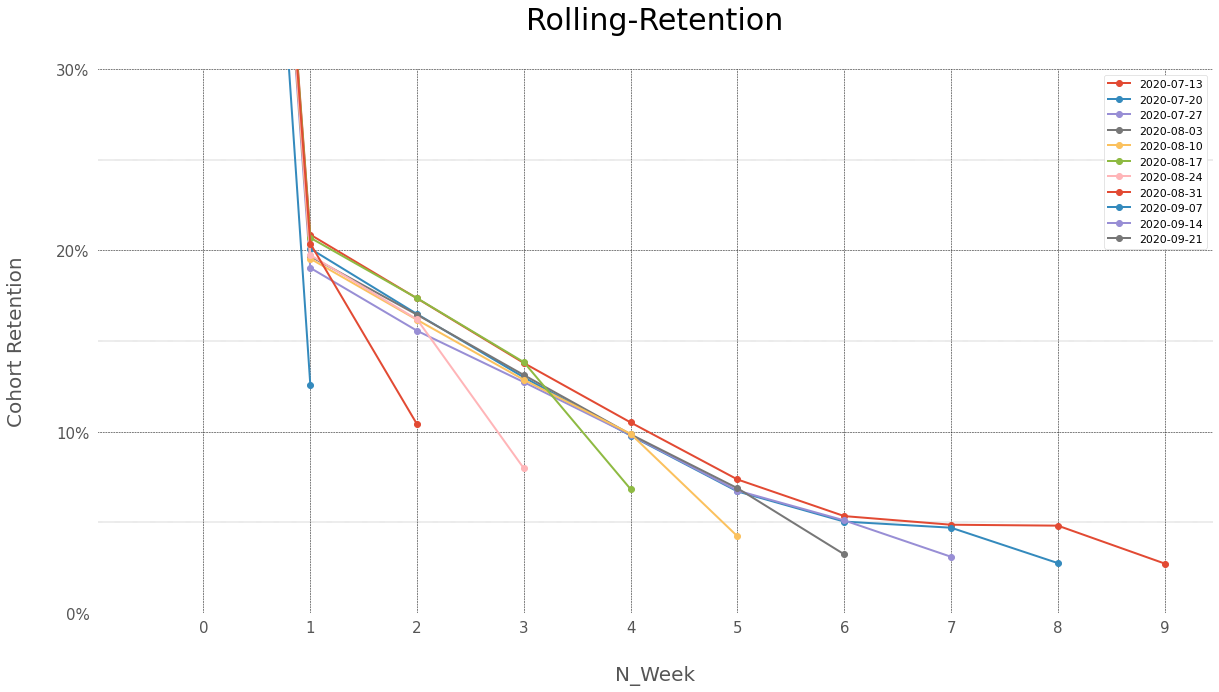

In [21]:

#    Последние 10 недель с приближением(zoom).

rolling_retention(full_data, last_n_weeks=10, zoom=30)

In [22]:

#    А вот так выглядит стильная таблица для Rolling Retention по неделям. 
#    Чуда не произошло - первая неделя самая результативная, дальше retention уменьшается.

rolling_retention(full_data, last_n_weeks=16, presentation_type='style')

N_Week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cohorts,,,,,,,,,,,,,,,,
2020-06-01,100.00%,19.56%,16.50%,13.26%,10.16%,7.08%,5.39%,4.74%,4.72%,4.72%,4.72%,4.72%,4.72%,4.72%,4.72%,2.79%
2020-06-08,100.00%,19.58%,16.07%,12.74%,9.41%,6.76%,5.33%,4.86%,4.83%,4.82%,4.82%,4.82%,4.82%,4.82%,2.99%,
2020-06-15,100.00%,19.54%,16.40%,13.17%,9.68%,6.76%,5.14%,4.74%,4.73%,4.73%,4.73%,4.73%,4.73%,3.01%,,
2020-06-22,100.00%,20.02%,16.53%,13.61%,10.33%,7.35%,5.65%,5.21%,5.17%,5.17%,5.17%,5.17%,3.20%,,,
2020-06-29,100.00%,20.57%,16.96%,13.61%,10.21%,7.25%,5.66%,5.30%,5.28%,5.28%,5.28%,3.04%,,,,
2020-07-06,100.00%,20.34%,16.85%,13.45%,10.13%,7.25%,5.59%,5.16%,5.12%,5.12%,3.13%,,,,,
2020-07-13,100.00%,19.97%,16.57%,13.22%,9.77%,6.91%,5.35%,4.98%,4.96%,2.86%,,,,,,
2020-07-20,100.00%,20.09%,16.49%,12.99%,9.78%,6.70%,5.03%,4.70%,2.74%,,,,,,,
2020-07-27,100.00%,19.04%,15.56%,12.73%,9.81%,6.74%,5.10%,3.09%,,,,,,,,
